For this dataset, I have chosen to predict the outcome (`Disposition Code`) of a given call. 

After the EDA, I have identified the following features as potential predictors:
- Call Received	
- Tencode

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data = pd.read_csv('Metro_Nashville_Police_Department_Calls_for_Service.csv', index_col='Call Received', parse_dates=True, usecols= ['Tencode','Disposition Code','Call Received'])

In [3]:
data.sort_index(inplace=True)

In [4]:
data

,Tencode,Disposition Code
Call Received,,
2013-01-01 00:00:17,15,15
2013-01-01 00:01:07,83,11
2013-01-01 00:01:27,83,6
2013-01-01 00:02:08,96,12
2013-01-01 00:02:09,43,6
...,...,...
2021-03-17 23:56:25,3,10
2021-03-17 23:57:02,96,12
2021-03-17 23:58:11,43,4


In [5]:
data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8281717 entries, 2013-01-01 00:00:17 to 2021-03-17 23:59:34
Data columns (total 2 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Tencode           8281717 non-null  int64 
 1   Disposition Code  8236379 non-null  object
dtypes: int64(1), object(1)
memory usage: 189.6+ MB


### Feature Engineering

In order to get all the information we can from the features we have chosen, we'll extract `hour`, `day`, and `month` from Call Recieved:

In [6]:
data['hour'] = data.index.hour
data['day'] = data.index.day_name()
data['month'] = data.index.month_name()

Let's look at the amount of unique values we have in our target data. From the documentation, we know that there should be, at most, 19 different codes.

In [7]:
len(data['Disposition Code'].unique())

112

We have a bunch of values that are not specified in the documentation. They might not be actual errors, but for the sake of this project, we will only use the ones we know are good observations.

In [8]:
disposition= {
'1' :"M.P.D. REPORT COMPLETED",
'10' :"NO RESPONSE",
'11' :"DISREGARD / SIGNAL 9",
'12' :"LOCATION/BUILDING SECURE",
'13' :"FALSE CALL",
'14' :"ASSISTANCE REFUSED",
'15' :"COMMUNITY POLICING",
'2' :"ARREST, CUSTODIAL OR CITATION",
'3' :"CITATION - TRAFFIC",
'4' :"ASSISTED CITIZEN",
'5' :"GONE ON ARRIVAL",
'6' :"ASSISTED OTHER UNIT",
'7' :"ADVISORY / NOTICE FORM GIVEN",
'8' :"ADVISED IN CIVIL CASE",
'9' :"SUBJECT WARNED",
'A' :"CLOSED BY ARREST",
'C' :"CLOSED",
'O' :"OPEN",
'P' :"PENDING",
}

In [9]:
df = pd.DataFrame()
for k,v in disposition.items():
    df = df.append(data[data['Disposition Code'] == k])
df.head()

,Tencode,Disposition Code,hour,day,month
Call Received,,,,,
2013-01-01 00:07:20,43,1,0,Tuesday,January
2013-01-01 00:09:58,45,1,0,Tuesday,January
2013-01-01 00:29:32,45,1,0,Tuesday,January
2013-01-01 00:31:26,43,1,0,Tuesday,January
2013-01-01 00:31:54,51,1,0,Tuesday,January


In [10]:
len(df['Disposition Code'].unique())

15

This is much better.

Now, let's One-Hot encode our categorical variables for modeling:

In [11]:
df.Tencode = df.Tencode.astype('category')
df.hour = df.hour.astype('category')

In [12]:
df_nz = pd.get_dummies(df[['Tencode','hour','day','month']])

In [13]:
y = pd.get_dummies(df['Disposition Code'])

# Modeling

For this project, I have decided to use an ANN (Artificial Neural Network) given the amount of data we have. This will allow us to get a good model with minimal tuning and training times.


First, we import the packages we'll be using:

In [15]:
from keras.models import Sequential
from keras.metrics import TopKCategoricalAccuracy
from keras.layers import Dense, InputLayer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

To streamline the process, let's define a function that creates a neural network and returns it:

In [16]:
def get_model(n_inputs, n_outputs):
    
    model = Sequential()
    model.add(InputLayer(input_shape=(n_inputs,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(loss='mse', optimizer='adam', metrics=[TopKCategoricalAccuracy(k=3)]) #our evaluation metric will be based on the real outcome being in the top three predicted variable.
    return model

Now, let's create a function to which we can pass our data to train the model and evaluate it:

In [32]:
def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=2)
    
    # evaluate a model using repeated k-fold cross-validation  
    cv = KFold(n_splits=3, shuffle=True)
    for train_ix, test_ix in cv.split(X):
        # prepare data
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
        # define model
        model = get_model(n_inputs, n_outputs)
        # fit model
        history = model.fit(X_train, y_train, verbose=1, epochs=50,validation_data=(X_test, y_test), callbacks=[es])
        # make a prediction on the test set
        yhat = model.predict(X_test)
        # round probabilities to class labels
        yhat = yhat.round()
        #Plot Accuracy and Loss
        plt.figure(figsize=(20,15))
        plt.subplot(211)
        plt.title('Accuracy')
        plt.plot(history.history['top_k_categorical_accuracy'], label='train')
        plt.plot(history.history['val_top_k_categorical_accuracy'], label='test')
        plt.legend()
        plt.subplot(212)
        plt.title('Loss')
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show() 
        
    return model, history

Train on 4118024 samples, validate on 2059012 samples
Epoch 1/50
4118024/4118024 [==============================] - 119s 29us/step - loss: 0.0415 - top_k_categorical_accuracy: 0.8304 - val_loss: 0.0414 - val_top_k_categorical_accuracy: 0.8319
Epoch 2/50
4118024/4118024 [==============================] - 117s 28us/step - loss: 0.0414 - top_k_categorical_accuracy: 0.8324 - val_loss: 0.0414 - val_top_k_categorical_accuracy: 0.8319
Epoch 3/50
4118024/4118024 [==============================] - 116s 28us/step - loss: 0.0414 - top_k_categorical_accuracy: 0.8324 - val_loss: 0.0414 - val_top_k_categorical_accuracy: 0.8323
Epoch 4/50
4118024/4118024 [==============================] - 116s 28us/step - loss: 0.0414 - top_k_categorical_accuracy: 0.8326 - val_loss: 0.0414 - val_top_k_categorical_accuracy: 0.8322
Epoch 5/50
4118024/4118024 [==============================] - 116s 28us/step - loss: 0.0414 - top_k_categorical_accuracy: 0.8326 - val_loss: 0.0414 - val_top_k_categorical_accuracy: 0.8324
E

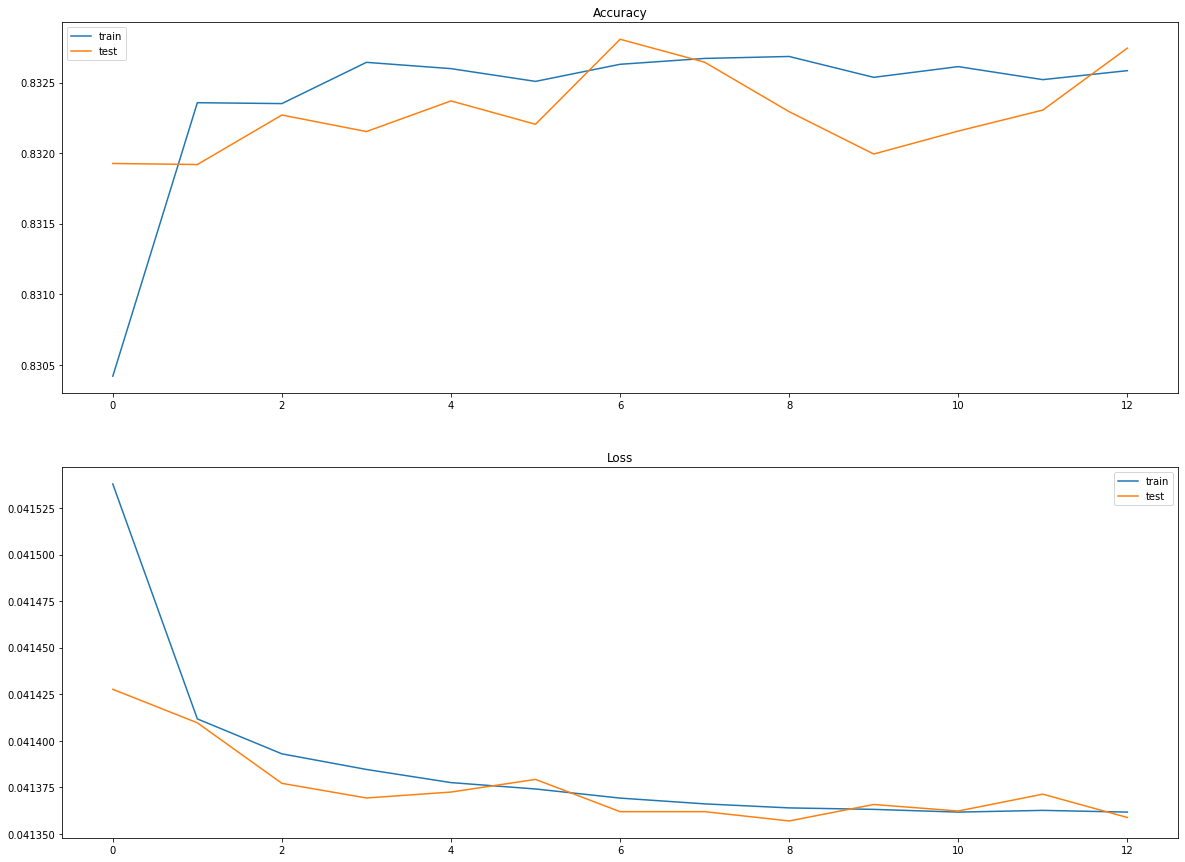

Train on 4118024 samples, validate on 2059012 samples
Epoch 1/50
4118024/4118024 [==============================] - 121s 29us/step - loss: 0.0415 - top_k_categorical_accuracy: 0.8301 - val_loss: 0.0414 - val_top_k_categorical_accuracy: 0.8326
Epoch 2/50
4118024/4118024 [==============================] - 121s 29us/step - loss: 0.0414 - top_k_categorical_accuracy: 0.8322 - val_loss: 0.0414 - val_top_k_categorical_accuracy: 0.8327
Epoch 3/50
4118024/4118024 [==============================] - 122s 30us/step - loss: 0.0414 - top_k_categorical_accuracy: 0.8322 - val_loss: 0.0414 - val_top_k_categorical_accuracy: 0.8332
Epoch 4/50
4118024/4118024 [==============================] - 122s 30us/step - loss: 0.0414 - top_k_categorical_accuracy: 0.8323 - val_loss: 0.0414 - val_top_k_categorical_accuracy: 0.8329
Epoch 5/50
4118024/4118024 [==============================] - 121s 29us/step - loss: 0.0414 - top_k_categorical_accuracy: 0.8323 - val_loss: 0.0414 - val_top_k_categorical_accuracy: 0.8330
E

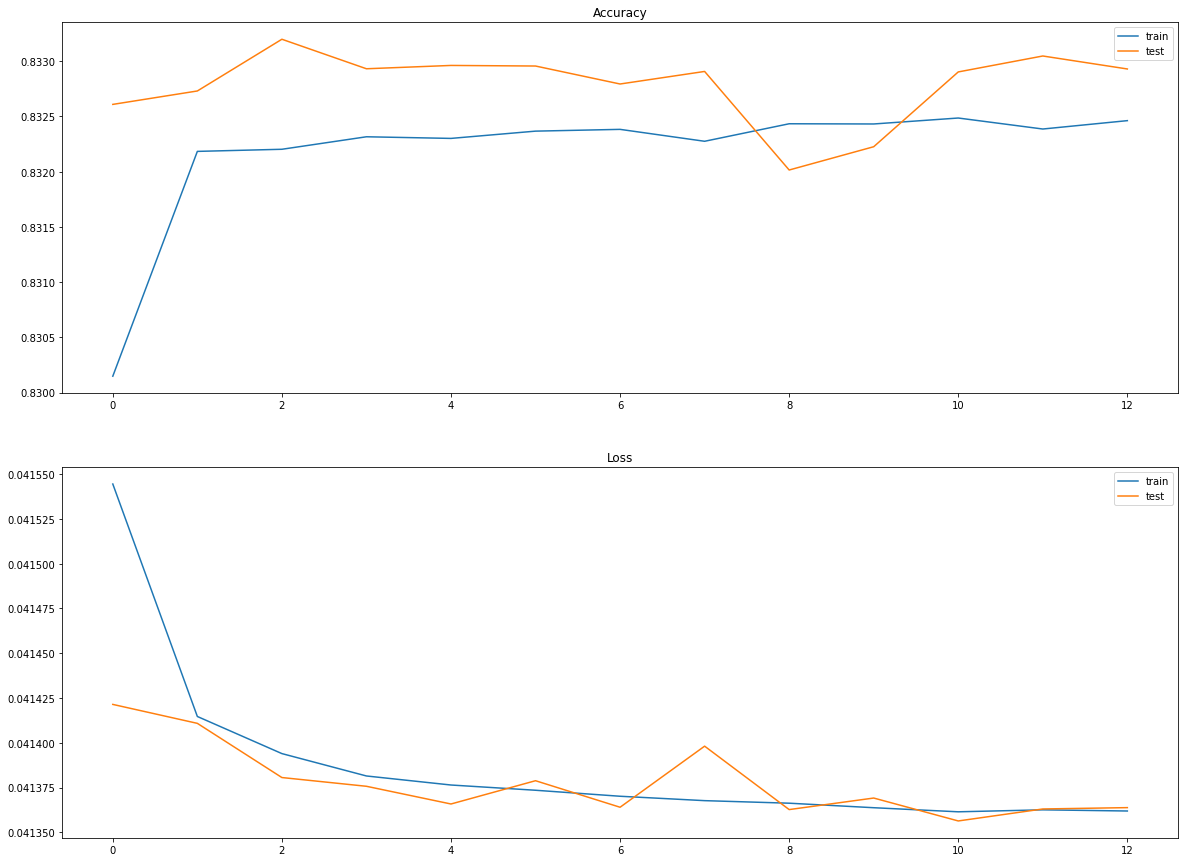

Train on 4118024 samples, validate on 2059012 samples
Epoch 1/50
4118024/4118024 [==============================] - 119s 29us/step - loss: 0.0415 - top_k_categorical_accuracy: 0.8300 - val_loss: 0.0414 - val_top_k_categorical_accuracy: 0.8320
Epoch 2/50
4118024/4118024 [==============================] - 117s 28us/step - loss: 0.0414 - top_k_categorical_accuracy: 0.8323 - val_loss: 0.0414 - val_top_k_categorical_accuracy: 0.8323
Epoch 3/50
4118024/4118024 [==============================] - 125s 30us/step - loss: 0.0414 - top_k_categorical_accuracy: 0.8325 - val_loss: 0.0414 - val_top_k_categorical_accuracy: 0.8324
Epoch 4/50
4118024/4118024 [==============================] - 119s 29us/step - loss: 0.0414 - top_k_categorical_accuracy: 0.8325 - val_loss: 0.0414 - val_top_k_categorical_accuracy: 0.8322
Epoch 5/50
4118024/4118024 [==============================] - 120s 29us/step - loss: 0.0414 - top_k_categorical_accuracy: 0.8325 - val_loss: 0.0414 - val_top_k_categorical_accuracy: 0.8325
E

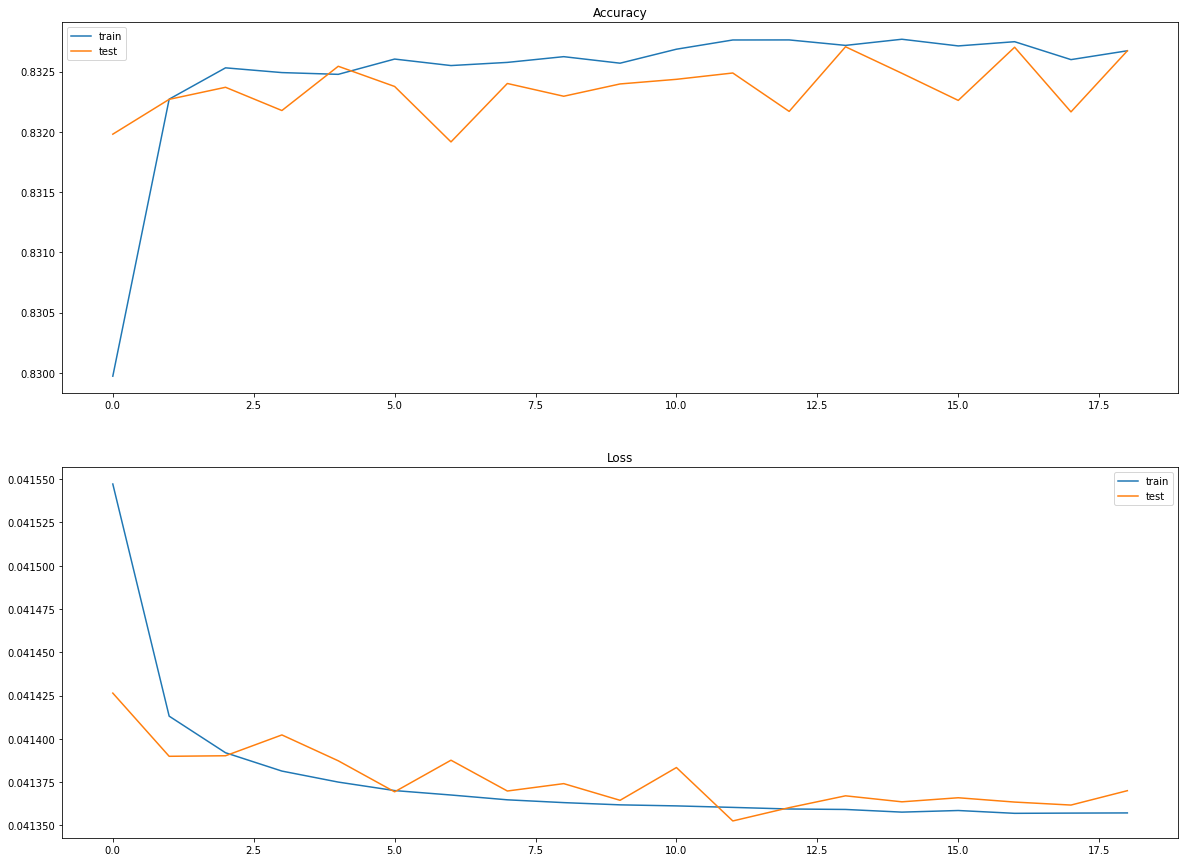

In [33]:
model, history = evaluate_model(df_nz, y)

We got an accuracy of 83%, this means: It generates three possible outcomes amongst which the real outcome is present 83% of the time.

# Exporting our model

In [37]:
import pickle
import keras
best_model = model
best_model.version = 1.0
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.keras_version = keras.__version__
best_model.X_columns = [col for col in df_nz.columns]
modelpath = 'outcome_predictor.pkl'
pickle.dump(best_model, open(modelpath, 'wb'))